# Problem 6: Phoneme classification 
[Ref: Elements of statistical learning]

Prof. V. I. Morgenshtern

Solver: A. Regensky

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import numpy as np
import cvxpy as cvx

You should have version 1.0.0 of cvxpy for this code to work. 

In [2]:
cvx.__version__

'1.0.0'

Write a program to classify the phoneme data using logic regression on raw features and logistic regression with splines. Your goal is to reproduce results in Lecture 7, Section 3. The phone data is in phoneme data.txt and the description of the data is in phoneme info.txt file.

* Extract the data corresponding to ‘aa’ and ‘ao’ phonemes.

In [3]:
filename="phoneme_data.txt"

# Read only data corresponding to 'aa' and 'ao' phonemes
data = []
labels = []
with open(filename,'r') as f:
    for dataline in [x.split(',') for x in f.readlines() if x.split(',')[-2]=='aa' or x.split(',')[-2]=='ao']:
        data.append(dataline[1:-2])
        labels.append(dataline[-2])
data = np.asarray(data, dtype='float')

# Translate labels to targets {0: ao, 1: aa}
targets = np.array([1 if label=='aa' else 0 for label in labels])

* Plot the data.

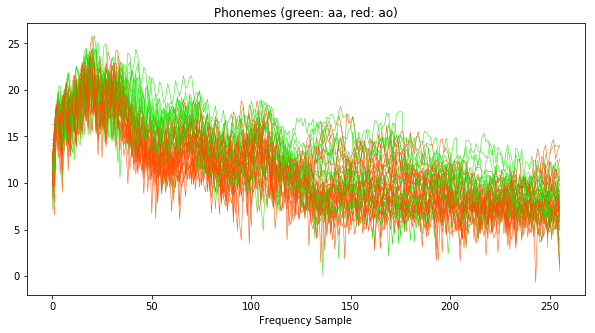

In [4]:
# Create figure
plt.figure(figsize=(10,5))

# Plot only a small fraction (0.025) of the data. Otherwise, the figure would be extremely dense.
x = np.arange(data.shape[1])
for i in range(int(data.shape[0]*0.025)):
    plt.plot(x,data[i],color=[.1,.9,0] if targets[i]==1 else [1,0.3,0],linewidth=.5)

# Adapt plot labels/title
plt.xlabel('Frequency Sample')
plt.title('Phonemes (green: aa, red: ao)')
plt.show()

* Split the data into the training and the test set.

In [5]:
# 80% in train set, 20% in test set
n = data.shape[0]
ntrain = int(.8*n)
ntest = n-ntrain
print("Total: {0}\nTraining set: {1}\nTest set: {2}".format(n,ntrain,ntest))

# Split data into a random training and test set
shuffled_idxs = np.random.permutation(n)

# someSet[0]: features, someSet[1]: label/target
trainSet = (data[shuffled_idxs[:ntrain]],targets[shuffled_idxs[:ntrain]])
testSet = (data[shuffled_idxs[ntrain:]],targets[shuffled_idxs[ntrain:]])

# Print the count of aa's and ao's in trainSet
aaExamples = np.sum(trainSet[1]==1)
aoExamples = np.sum(trainSet[1]==0)

print("Examples:\n- aa: {0}\n- ao: {1}".format(aaExamples, aoExamples))

Total: 1717
Training set: 1373
Test set: 344
Examples:
- aa: 558
- ao: 815


* Fit the logistic regression to the raw data. In this case your output variables are binary, corresponding to ‘aa’ or ‘ao’ phonemes, your input variable are the p = 256 dimensional vectors with frequency information x. Report performance on the train and the test set. Plot the coefficients θ.

Hint: You don’t need no write a gradient descent algorithm to fit the model in this problem. Use cvxpy instead.

Training set accuracy: 0.8900218499635834
Test set accuracy: 0.7848837209302325


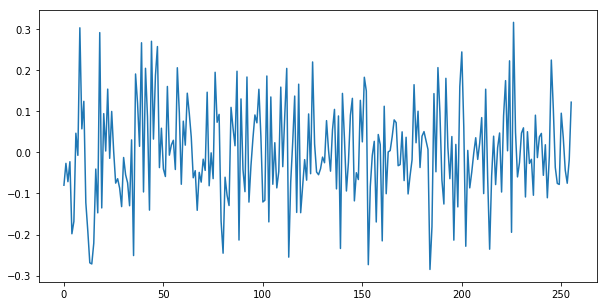

In [6]:
def trainLogistic(Xtrain, ytrain, verbose=False, solver=cvx.ECOS):
    """Returns the optimized parameters for logistic regression using the 
    given training data (ytrain, Xtrain).
    Each row of ytrain and Xtrain correspond to a single training example."""
    
    #theta = cvx.Variable(shape=(Xtrain.shape[1]))
    theta = cvx.Variable(Xtrain.shape[1])
    # The log likelihood objective can be transformed to this.
    # Hint: look up what cvxpy's logistic function does in their documentation
    objective = cvx.Maximize(ytrain.T.dot(Xtrain)*theta - cvx.sum(cvx.logistic(Xtrain*theta)))
    problem = cvx.Problem(objective)
    problem.solve(verbose=verbose, solver=solver)
    return theta.value

def accuracyLogistic(theta, X, y):
    """Calculate the accuracy of logistic regression with the parameters theta on the
    set (X,y)
    - theta: parameters
    - X: input set (each row corresponds to one example)
    - y: target set"""
    predicted = theta.dot(X.T) > 0
    correct = np.sum(predicted==y)
    accuracy = float(correct)/float(X.shape[0])
    return accuracy

# Train theta
theta = trainLogistic(trainSet[0], trainSet[1], verbose=False)

# Report performance on train and test set
accuracyTrainU = accuracyLogistic(theta, trainSet[0], trainSet[1])
accuracyTestU = accuracyLogistic(theta, testSet[0], testSet[1])

print("Training set accuracy: {0}\nTest set accuracy: {1}".format(accuracyTrainU, accuracyTestU))

# Plot the coefficients
plt.figure(figsize=(10,5))
plt.plot(np.arange(theta.shape[0]), theta)
plt.show()

* Since there are many correlated features, you should filter them using a smooth basis of cubic splines.
* Decide beforehand on a series of five different choices for the number and position of the knots. Form the p × D spline matrix H, where D ≪ p is the number of degrees of freedom in the model that is determined by the number and positions of the knots. Your new features are $x^* = H^Tx$.
* Fit the spline-regularized logistic regression to each choice.
* Use the test set to make the final selection of the positions of the knots.
* Report performance on the train and the test set. Compare to the unregularized case. Plot the coefficients θ.

Train with 4 knots...
Train with 8 knots...
Train with 12 knots...
Train with 16 knots...
Train with 18 knots...

Spline regularized accuracies with 18 knots:
Test set: 0.7906976744186046
Training set: 0.8113619810633649

Unregularized accuracies:
Test set: 0.7848837209302325
Training set: 0.8900218499635834


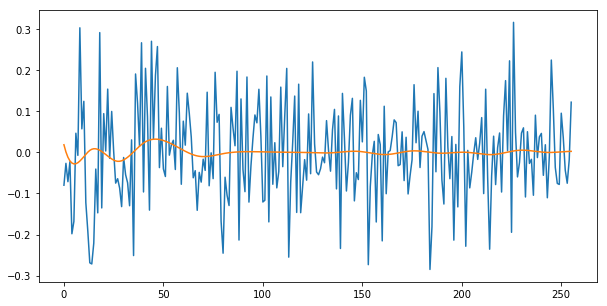

In [7]:
def cubicSplineMatrix(values, knots=[]):
    """Returns the cubic spline matrix evaluated at values.
        - values: splines are evaluated at these positions
        - knots (optional): knots of splines are located at these positions
        - shape: [n_values, n_knots+4]"""
    knots = np.asarray(knots)
    values = np.asarray(values)
    n_knots = knots.shape[0]
    n_values = values.shape[0]
    
    # Initialize cubic spline matrix
    S = np.zeros([n_values, n_knots+4])
    
    # Fill matrix
    S[:,0] = 1
    S[:,1] = values
    S[:,2] = values**2
    S[:,3] = values**3
    for i in range(n_knots):
        S[:,i+4] = (np.clip(values-knots[i],0,None))**3
        
    return S

# Define input to cubicSplineMatrix
frequencies = np.arange(data.shape[1])

n_knots = [4, 8, 12, 16, 18]

# Test accuracy of spline regularization with n_knots
bestTheta = np.zeros(data.shape[1])
bestAccuracyTest = 0
bestNKnots = n_knots[0]
for n in n_knots:
    knots = np.linspace(0,data.shape[1],n+2)[1:-1] # No knot at 0 or end
    
    # Get cubic spline matrix
    H = cubicSplineMatrix(frequencies, knots)
    
    # Translate high dimensional input
    # Transpose training input (X), then transpose features. This is different from the lecture notes
    # as here, the features are saved row-wise in X. (In the lecture notes x represents one training 
    # example and is a column vector)
    features = H.T.dot(trainSet[0].T).T
    
    # Train
    print("Train with {0} knots...".format(n))
    beta = trainLogistic(features, trainSet[1], verbose=False)
    
    # Get corresponding higher dimensional theta
    thetaSmooth = H.dot(beta)
    
    # Measure accuracy
    accuracyTest = accuracyLogistic(thetaSmooth, testSet[0], testSet[1])
    
    # Is best?
    if (accuracyTest > bestAccuracyTest):
        bestAccuracyTest = accuracyTest
        bestTheta = thetaSmooth
        bestNKnots = n
print("")
        
# Calculate accuracy on training set for bestTheta
accuracyTrain = accuracyLogistic(bestTheta, trainSet[0], trainSet[1])

print("Spline regularized accuracies with {0} knots:\nTest set: {1}\nTraining set: {2}\n".format(bestNKnots, bestAccuracyTest, accuracyTrain))
print("Unregularized accuracies:\nTest set: {0}\nTraining set: {1}".format(accuracyTestU, accuracyTrainU))

plt.figure(figsize=(10,5))
plt.plot(frequencies, theta)
plt.plot(frequencies, bestTheta)
plt.show()